Classification of Protein Sequences via LSTMs and TCNs with Skip Connections


Proteins are large, complex bio-molecules responsible for carrying out multiple critical bodily functions.  They are composed of chains (long variable-order sequences with repeats) of 20 possible amino acids.  The constituent amino acids that make up a protein determine its unique structure as well as function.  In this assignment, we will use deep learning and a protein database called 'Pfam' to classify amino acid sequences into their protein families. 

In [ ]:
#1. First download the dataset from here: https://www.kaggle.com/googleai/pfam-seed-random-split
#2. Upload the data folder from #1 to your Google Drive
#MOUNTING GOOGLE DRIVE WHERE DATA IS STORED
from google.colab import drive
drive.mount('/gdrive', force_remount=True)


Mounted at /gdrive


In [ ]:
#Required Imports
%matplotlib inline

import gc
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D


In [ ]:
# Reading in the Pfam dataset
# data is randomly split into three folders [train(80%), test(10%), dev(10%)]
# reading and concatenating data for each folder.

data_path = '/gdrive/My Drive/random_split/' #Make sure to modify to your location
print('Available data', os.listdir(data_path))

def read_data(partition):
  data = []
  for fn in os.listdir(os.path.join(data_path, partition)):
    with open(os.path.join(data_path, partition, fn)) as f:
      data.append(pd.read_csv(f, index_col=None))
  return pd.concat(data)

# reading all data_partitions and visualizing (head) of the data
df_train = read_data('train')
df_val = read_data('dev')
df_test = read_data('test')
df_train.head()

Available data ['dev', 'random_split', 'train', 'test']


,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


# Overview of Data Components:

*sequence:* This is the input to the model, an amino acid sequence for a protein. There are 20 common amino acids (frequency > 1,000,000), and 4 amino acids that are uncommon: U, B, O, Z, and X stands for an unknown or generic/'wild-card' amino acid.

*family_accession:* These are the labels (outputs) of the model. Accession number is in the form PFxxxxx.y, where xxxxx is the family accession, and y is the version number. Some values of y are greater than ten, and so 'y' has two digits.

*sequence_name:* Sequence name, in the form "uniprot_accession_id/start_index-end_index".

*aligned_sequence:* The aligned version of the *sequence* (above) with gaps retained.

*family_id:* One word name for protein family.


**Getting Familiar with the Data:** the following few cells will help you get familiar with the data, an important step to allow you to build your deep learning sequence model

In [ ]:
# An example unaligned sequence, input to the model
# Each character represents one of the 25 (20 common + 4 uncommon + 1 'wild-card') 
# amino acids in the sequence.

df_train.head(1)['sequence'].values[0]

'PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAILAAAGCAAPFEEFSSADAFSSTHVFGTCRMGHDPMRNVVDGWGRSHRWPNLFVADASLFPSSGGGESPGLTIQALALRT'

In [ ]:
# Given data size (number of sequences in each set)
print('Train size: ', len(df_train))
print('Val size: ', len(df_val))
print('Test size: ', len(df_test))

Train size:  1086741
Val size:  126171
Test size:  126171


In [ ]:
#Getting a sense of the data: number of families/classes
def calc_unique_cls(train, test, val):
  """
  Prints # unique classes in data sets.
  """
  train_unq = np.unique(train['family_accession'].values)
  val_unq = np.unique(val['family_accession'].values)
  test_unq = np.unique(test['family_accession'].values)

  print('Number of unique classes in Train: ', len(train_unq))
  print('Number of unique classes in Val: ', len(val_unq))
  print('Number of unique classes in Test: ', len(test_unq))

# Unique classes in the given dataset : [df_train, df_val and df_test]
calc_unique_cls(df_train, df_test, df_val)

Number of unique classes in Train:  17929
Number of unique classes in Val:  13071
Number of unique classes in Test:  13071


**Problem 1a:** Use the code in the following cell to plot the typical lengths of sequences in this dataset.  What is the the approximate most prevalent/common sequence length?  You will use this later for pre-processing your sequences.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

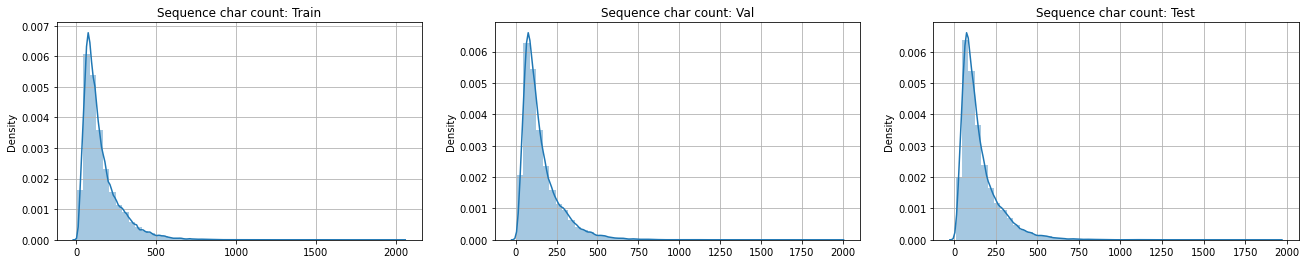

In [ ]:
# The code below will allow you to plot the typical lengths of
# amino acid sequences for train, val, and test datasets.  

df_train['seq_char_count']= df_train['sequence'].apply(lambda x: len(x))
df_val['seq_char_count']= df_val['sequence'].apply(lambda x: len(x))
df_test['seq_char_count']= df_test['sequence'].apply(lambda x: len(x))

def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)


plt.subplot(1, 3, 1)
plot_seq_count(df_train, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(df_val, 'Val')

plt.subplot(1, 3, 3)
plot_seq_count(df_test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()


**The most prevalent sequence length is appproximately 100.**

Amino acids are represented in a protein sequence with their corresponding 1 letter code; for example, the code for alanine is (A), arginine is (R), and so on. The complete list of amino acid codes is [here](https://www.ddbj.nig.ac.jp/ddbj/code-e.html) under 'Amino Acid Codes'.

In [ ]:
#Determine the number of instances of each amino acid code across all sequences
#in train, val, and test sets 
def get_code_freq(df, data_name):
  
  df = df.apply(lambda x: " ".join(x))
  
  codes = []
  for i in df: # concatination of all codes
    codes.extend(i)

  codes_dict= Counter(codes)
  codes_dict.pop(' ') # removing white space
  
  print(f'Codes: {data_name}')
  print(f'Total unique codes: {len(codes_dict.keys())}')

  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]
  
# train code sequence
train_code_freq = get_code_freq(df_train['sequence'], 'Train')

# val code sequence
val_code_freq = get_code_freq(df_val['sequence'], 'Val')

# test code sequence
test_code_freq = get_code_freq(df_test['sequence'], 'Test')

def plot_code_freq(df, data_name):
  
  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y='Freq', data=df)

Codes: Train
Total unique codes: 25
Codes: Val
Total unique codes: 22
Codes: Test
Total unique codes: 24


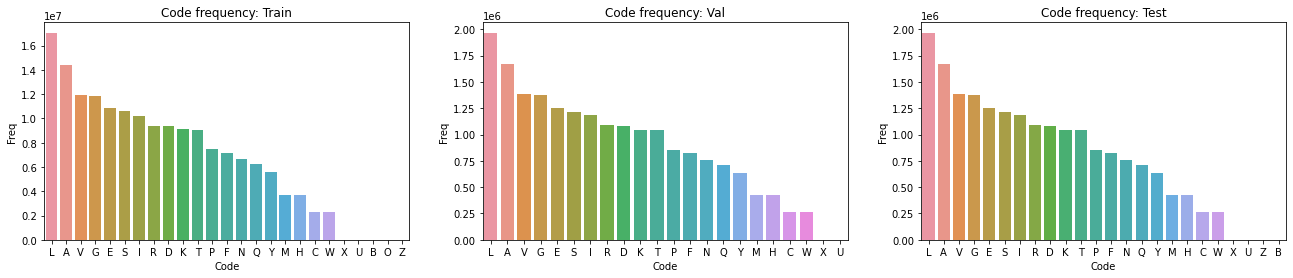

In [ ]:
#Plot the Amino Acid Code frequency for this dataset
plt.subplot(1, 3, 1)
plot_code_freq(train_code_freq, 'Train')

plt.subplot(1, 3, 2)
plot_code_freq(val_code_freq, 'Val')

plt.subplot(1, 3, 3)
plot_code_freq(test_code_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

In [ ]:
# Since our dataset is large, we will consider only the top 1000 most-observed
# protein classes/families due to limited computational power.

classes = df_train['family_accession'].value_counts()[:1000].index.tolist()
len(classes)

# Filtering data based on considered 1000 classes.
train_sm = df_train.loc[df_train['family_accession'].isin(classes)].reset_index()
val_sm = df_val.loc[df_val['family_accession'].isin(classes)].reset_index()
test_sm = df_test.loc[df_test['family_accession'].isin(classes)].reset_index()

print('Data size after considering 1000 classes for each data split:')
print('Train size :', len(train_sm))
print('Val size :', len(val_sm))
print('Test size :', len(test_sm))

# No. of unique classes after reducing the data size.

calc_unique_cls(train_sm, test_sm, val_sm)

Data size after considering 1000 classes for each data split:
Train size : 439493
Val size : 54378
Test size : 54378
Number of unique classes in Train:  1000
Number of unique classes in Val:  1000
Number of unique classes in Test:  1000


Here we start developing our **Deep Learning** model.  First task is to preprocess the amino acid sequences in our dataset.

In [ ]:
# The code below creates our amino acid code sequence dictionary
# https://dmnfarrell.github.io/bioinformatics/mhclearning
# 1 letter code for 20 natural amino acids

codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [ ]:
#Now we will encode our sequences made of letters into sequences of integers
def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids (and X 'wild-card') are taken into consideration.
    Remaining 4 uncommon amino acids are categorized as 0 (so not included).
  """
  
  encode_list = []
  for row in data['sequence'].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  
  return encode_list
  
train_encode = integer_encoding(train_sm) 
val_encode = integer_encoding(val_sm) 
test_encode = integer_encoding(test_sm) 

#Just to visualize an example of the output
print(train_encode[0])

[11 10 15 11 11 11 12 16  9  8  7 15  1 17 18 17  4  1  3 10 12 20 18  6
 16  8 17  8  3  4  3  8 10  3  1 18  6 11 10 13 12  4  9 18  7  8 18 12
 12 12 12  6  1 15  5  4 17 20  8  8  1  6  4 15  6 16  6 18  8  2 18 12
  6  1  1  1 15 10 18 14 15  6  3  8 18  8  8  8 16 20 18 20 18  3 12  1
  4  1  9  3  7  9 13 17 18  1  8 11  6  4  6 12 17  8  9]


In [ ]:
# The code to encode labels/output variable y (amino acid family/class) into integers
le = LabelEncoder()

y_train_le = le.fit_transform(train_sm['family_accession'])
y_val_le = le.transform(val_sm['family_accession'])
y_test_le = le.transform(test_sm['family_accession'])

y_train_le.shape, y_val_le.shape, y_test_le.shape

((439493,), (54378,), (54378,))

**Problem 1b:** Now we must ensure all sequences are the same length since our sequence model can only take in fixed-size inputs.  Pad the sequences using Keras *pad_sequences* [function](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences), using the max_length you determined in part (a).  Use 'post' padding to pad with 0 if the total sequence length is less than max_length or truncate the sequence (if longer) to max_length.

In [ ]:
# Your code below for padding sequences
import tensorflow as tf
import keras
max_length = 100 #Fill this in from part 1a
train_pad = tf.keras.preprocessing.sequence.pad_sequences(train_encode, padding='post', maxlen = max_length)
val_pad = tf.keras.preprocessing.sequence.pad_sequences(val_encode, padding='post', maxlen = max_length)
test_pad = tf.keras.preprocessing.sequence.pad_sequences(test_encode, padding='post', maxlen = max_length)

**Problem 1c:** Now encode input sequences and output labels using one-hot encoding (zeros everywhere except for at location of the appropriate amino acid code) using Keras *to_categorical* function.

In [ ]:
#Your code here: One hot encoding of sequences
onehot_train_pad = tf.keras.utils.to_categorical(train_pad, num_classes=None, dtype="float32")
onehot_val_pad = tf.keras.utils.to_categorical(val_pad, num_classes=None, dtype="float32")
onehot_test_pad = tf.keras.utils.to_categorical(test_pad, num_classes=None, dtype="float32")

In [ ]:
# Your code here: One hot encoding of outputs
onehot_y_train_le = tf.keras.utils.to_categorical(y_train_le, num_classes=None, dtype="float32")
onehot_y_val_le = tf.keras.utils.to_categorical(y_val_le, num_classes=None, dtype="float32")
onehot_y_test_le = tf.keras.utils.to_categorical(y_test_le, num_classes=None, dtype="float32")

In [ ]:
#Utility functions: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# Utility function: Display model score(Loss & Accuracy) across all sets.

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

**Problem 1d:** Implement code here for a [bidirectional LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) using Keras Functional or Sequential API.  Unlike RNNs which only take input from the previous timestep, LSTMs can remember information from the distant past via gating mechanisms.  Bidirectional LSTMs can incorporate contextual information from both past and future, improving their performance even more compared to unidirectional LSTMs on sequential data.

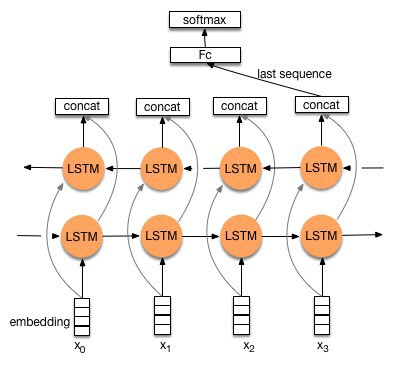

In [ ]:
# Implement your code here:
# Hint: use an embedding layer to project your sequence data to a higher dimension,
# and use the diagram above for some ideas on layers to include in your model.
# Remember to compile your model after designing it.
from keras.models import Sequential
model1 = Sequential()
model1.add(tf.keras.layers.Embedding(21, 32, input_length=100))
model1.add(Bidirectional(LSTM(32, return_sequences=True)))
model1.add(Bidirectional(LSTM(32)))
model1.add(Dense(1000))
model1.add(Activation('softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

**Problem 1e:** Now train your model using Keras model.fit function. Add the given early stopping as a parameter to your fit function to prevent overtraining.  Use at least 25 epochs (it will take 15-20min to train with GPU: Remember turn GPU on by going to Runtime --> Change Runtime Type --> GPU) and a batch size of 256.  Validate on your padded validation sequences from above.

In [ ]:
# Train your model using Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history1 = model1.fit(train_pad,onehot_y_train_le,epochs = 25,batch_size = 256,callbacks=[es],validation_data=(val_pad, onehot_y_val_le))#Your code here


Epoch 1/25
1717/1717 [==============================] - 63s 37ms/step - loss: 5.6127 - accuracy: 0.0363 - val_loss: 5.0818 - val_accuracy: 0.0561
Epoch 2/25
1717/1717 [==============================] - 61s 36ms/step - loss: 4.5176 - accuracy: 0.1187 - val_loss: 4.0786 - val_accuracy: 0.1715
Epoch 3/25
1717/1717 [==============================] - 61s 36ms/step - loss: 3.6844 - accuracy: 0.2365 - val_loss: 3.2908 - val_accuracy: 0.3086
Epoch 4/25
1717/1717 [==============================] - 61s 36ms/step - loss: 2.9782 - accuracy: 0.3687 - val_loss: 2.6844 - val_accuracy: 0.4239
Epoch 5/25
1717/1717 [==============================] - 61s 36ms/step - loss: 2.3531 - accuracy: 0.4960 - val_loss: 2.0602 - val_accuracy: 0.5603
Epoch 6/25
1717/1717 [==============================] - 61s 36ms/step - loss: 1.8219 - accuracy: 0.6101 - val_loss: 1.6387 - val_accuracy: 0.6500
Epoch 7/25
1717/1717 [==============================] - 61s 36ms/step - loss: 1.4288 - accuracy: 0.6953 - val_loss: 1.2999 -

1717/1717 [==============================] - 25s 15ms/step - loss: 0.1986 - accuracy: 0.9563
Train loss:  0.19855070114135742
Train accuracy:  0.9563451409339905
----------------------------------------------------------------------
213/213 [==============================] - 3s 15ms/step - loss: 0.2408 - accuracy: 0.9437
Val loss:  0.2407563477754593
Val accuracy:  0.9437088370323181
----------------------------------------------------------------------
213/213 [==============================] - 3s 15ms/step - loss: 0.2405 - accuracy: 0.9450
Test loss:  0.24050934612751007
Test accuracy:  0.9449777603149414


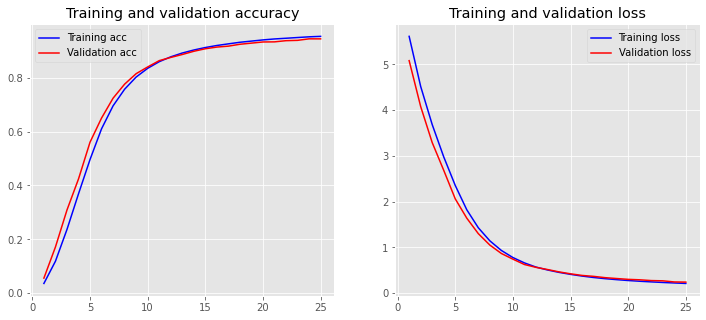

In [ ]:
# Show your model results and plots
display_model_score(model1,
    [train_pad, onehot_y_train_le],
    [val_pad, onehot_y_val_le],
    [test_pad, onehot_y_test_le],
    256)

plot_history(history1)

In [ ]:
#Save your model in case you need to run again to save time with training
model1.save_weights('/gdrive/My Drive/LSTM_Model1.h5')

**Problem #2a:** Now we will repeat the protein sequence classification task of Problem #1  using a ResNet based [temporal (1D) convolution network](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) with dilation.  **Use Keras functional API to design two convolutional blocks and then use the Add()** [function](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add) to combine your input (data) with the output of your 2nd convolutional block.

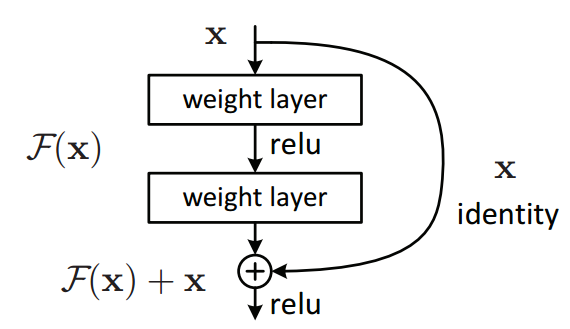

In [ ]:
#Add your code to define a residual block below, as shown in the diagram above
def residual_block(data, filters, d_rate):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """
  #Add your layers here
  mid1 = tf.keras.layers.Conv1D(filters = filters, kernel_size = 1, dilation_rate = d_rate)(data)
  mid2 = tf.keras.layers.Conv1D(filters = filters, kernel_size = 1, dilation_rate = d_rate)(mid1)
  mid3 = BatchNormalization()(mid2)
  mid4 = tf.keras.layers.Activation('relu')(mid3)
  x = tf.keras.layers.Add()([data, mid3])
  return x

In [ ]:
onehot_train_pad.shape, y_train_le.shape

((439493, 100, 21), (439493,))

1D temporal convolution network around the residual networks (called below using the definition you implemented in part a) with Keras [paper](https://www.biorxiv.org/content/10.1101/626507v4.full) which describes the final architecture in more detail.

In [ ]:
#Insert your code before and after the residual networks called below
#input
d_rate = 2
filters = 128
kernel_size = 3

inputs = keras.Input(shape=(100,21))
#initial conv
conv = tf.keras.layers.Conv1D(filters = filters, kernel_size = kernel_size, dilation_rate = d_rate)(inputs)

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

#Max Pooling
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=None, padding="valid", data_format="channels_last")(res2)
x = tf.keras.layers.Dropout(0.2, noise_shape=None, seed=None)(x)
x = tf.keras.layers.Flatten(data_format=None)(x)
#softmax classifier
x = tf.keras.layers.Softmax(axis=-1)(x)
x = tf.keras.layers.Dense(1000)(x)
outputs = x
#Compile your model
model2 = keras.Model(inputs=inputs, outputs=outputs)
model2.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],)




model trained with early stopping using 10 epochs and a batch size of 256.  Validated with one-hot-encoded validation data from above.

In [ ]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history2 = model2.fit(onehot_train_pad,y_train_le,epochs = 25,batch_size = 256,callbacks=[es],validation_data=(onehot_val_pad, y_val_le))#your code here


Epoch 1/25
1717/1717 [==============================] - 62s 36ms/step - loss: 6.3667 - accuracy: 0.0286 - val_loss: 5.8808 - val_accuracy: 0.0495
Epoch 2/25
1717/1717 [==============================] - 61s 35ms/step - loss: 5.1174 - accuracy: 0.1189 - val_loss: 4.8586 - val_accuracy: 0.1730
Epoch 4/25
1717/1717 [==============================] - 61s 35ms/step - loss: 4.8006 - accuracy: 0.1542 - val_loss: 4.5665 - val_accuracy: 0.2115
Epoch 5/25
1717/1717 [==============================] - 60s 35ms/step - loss: 4.5755 - accuracy: 0.1781 - val_loss: 4.3444 - val_accuracy: 0.2325
Epoch 6/25
1717/1717 [==============================] - 61s 35ms/step - loss: 4.4130 - accuracy: 0.1927 - val_loss: 4.2217 - val_accuracy: 0.2501
Epoch 7/25
1717/1717 [==============================] - 60s 35ms/step - loss: 4.2854 - accuracy: 0.2038 - val_loss: 4.0837 - val_accuracy: 0.2662
Epoch 8/25
1717/1717 [==============================] - 60s 35ms/step - loss: 4.1755 - accuracy: 0.2155 - val_loss: 3.9557 -

1717/1717 [==============================] - 19s 11ms/step - loss: 2.1792 - accuracy: 0.6640
Train loss:  2.1792149543762207
Train accuracy:  0.6639969348907471
----------------------------------------------------------------------
213/213 [==============================] - 2s 11ms/step - loss: 2.2170 - accuracy: 0.6590
Val loss:  2.2170281410217285
Val accuracy:  0.6589981317520142
----------------------------------------------------------------------
213/213 [==============================] - 2s 11ms/step - loss: 2.2305 - accuracy: 0.6524
Test loss:  2.230506181716919
Test accuracy:  0.6523777842521667


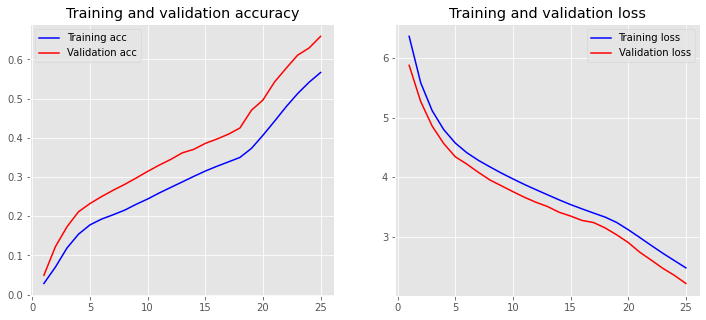

In [ ]:
#Plot loss and accuracy and evaluate your model.
plot_history(history2)
display_model_score(
    model2,
    [onehot_train_pad, y_train_le],
    [onehot_val_pad, y_val_le],
    [onehot_test_pad, y_test_le],
    256)



For the LSTM model, train accuracy is 0.9563451409339905, validation accuracy is 0.9437088370323181, test accuracy is 0.9449777603149414.

For the TCN model, train accuracy is 0.6639969348907471, validation accuracy is 0.6589981317520142, test accuracy is 0.6523777842521667.

While both models can be further improved through changing parameters, **the LSTM model has performed significantly better with observable higher accuracy when using the same computation time for each epoch with TCN**. The LSTM model has performed so well because it is able to precisely omit irrelevant information and selectively update cell states. RCN has not performed so effeciently probably because residual block is a less effective way of quality control within each epoch than forget gate.

**Another highly possible reason for the difference in performance is the difference of input and output data format.** Due to the different requirement for input shape, the input data is padded data while the output data is onehot categorical data for LSTM, vice versa is the case for RCN model. It is highly likely that onehot categorical data serves better as output than as input for better accuracy.

Despite the industry consensus that RCN is more advanced, it seems different models have their respective scenarios in which they perform better.